## Problem Statement

Modern computer networks and their connected applications have reached unprecedented growth with implementations  like  the  internet  of  things,  smart  homes,  and  software-defined  networks.  However, this  has  also  increased  the  potential  for  network intrusions,  which  are  a  continuous  threat  to  network infrastructures as they attempt to  compromise the major principles of computing systems: availability, authority,  confidentiality,  and  integrity.    These  threats  are  difficult  to  detect  unaided,  as  they  display indistinguishable  network  traffic  patterns  as  normal  functionality.    To  provide  enhanced  protection against  intrusions,  the  usage  of  machine  learning  for  NIDS  has  gained  traction  in  the  last  decade  as various  open-sourced  datasets  have  been  proposedand  established  by  multiple  research  groups globally.

In [2]:
import pandas as pd
import numpy as np

# Visualisation libraries
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

# For Garbage collection
import gc

# For hyperparam tuning
from sklearn.model_selection import GridSearchCV

# Data preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Classification report
from sklearn.metrics import classification_report

# Tensorflow and Keras
from keras.models import Sequential
from keras.layers import Dense
#For early stopping
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# Reading the input

input_df = pd.read_csv("train_dataset.csv")
input_df.head()

,Port Number,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Rx Dropped,Packets Tx Dropped,Packets Rx Errors,Packets Tx Errors,...,Unknown Load/Rate,Unknown Load/Latest,Latest bytes counter,is_valid,Table ID,Active Flow Entries,Packets Looked Up,Packets Matched,Max Size,Label
0,4,305111,25506841,100234870,284579,1657,0,0,0,0,...,0,0,0,1,0,6,992868,992744,-1,0
1,2,209,20671,6316631,274,96,0,0,0,0,...,183877,6303353,183877,1,0,8,90551,90494,-1,3
2,4,150,19774,6475473,3054,166,0,0,0,0,...,502,6439888,502,1,0,6,7516,7418,-1,2
3,1,4699,100986365,124574097,413351,2267,0,0,0,0,...,0,0,0,1,0,8,664849,664714,-1,0
4,3,990,104058,88896,778,792,0,0,0,0,...,715,7152,715,1,0,5,4328,4201,-1,1


In [4]:
#Reading the test dataset
X_test = pd.read_csv("test_dataset.csv")

## Exploratory Data Analysis

In [4]:
input_df.shape

(4998, 32)

In [5]:
input_df.columns

Index(['Port Number', 'Received Packets', 'Received Bytes', 'Sent Bytes',
       'Sent Packets', 'Port alive Duration (S)', 'Packets Rx Dropped',
       'Packets Tx Dropped', 'Packets Rx Errors', 'Packets Tx Errors',
       'Delta Received Packets', 'Delta Received Bytes', 'Delta Sent Bytes',
       'Delta Sent Packets', 'Delta Port alive Duration (S)',
       'Delta Packets Rx Dropped', ' Delta Packets Tx Dropped',
       'Delta Packets Rx Errors', 'Delta Packets Tx Errors',
       'Connection Point', 'Total Load/Rate', 'Total Load/Latest',
       'Unknown Load/Rate', 'Unknown Load/Latest', 'Latest bytes counter',
       'is_valid', 'Table ID', 'Active Flow Entries', 'Packets Looked Up',
       'Packets Matched', 'Max Size', 'Label'],
      dtype='object')

In [6]:
input_df.dtypes

Port Number                      int64
Received Packets                 int64
Received Bytes                   int64
Sent Bytes                       int64
Sent Packets                     int64
Port alive Duration (S)          int64
Packets Rx Dropped               int64
Packets Tx Dropped               int64
Packets Rx Errors                int64
Packets Tx Errors                int64
Delta Received Packets           int64
Delta Received Bytes             int64
Delta Sent Bytes                 int64
Delta Sent Packets               int64
Delta Port alive Duration (S)    int64
Delta Packets Rx Dropped         int64
 Delta Packets Tx Dropped        int64
Delta Packets Rx Errors          int64
Delta Packets Tx Errors          int64
Connection Point                 int64
Total Load/Rate                  int64
Total Load/Latest                int64
Unknown Load/Rate                int64
Unknown Load/Latest              int64
Latest bytes counter             int64
is_valid                 

### Distribution of target variable

In [7]:
target_distrib = input_df['Label'].value_counts()
target_distrib

0    2641
3     656
2     646
1     589
4     395
5      71
Name: Label, dtype: int64

In [8]:
labels = target_distrib.index
values = list(target_distrib)

fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent',
                             insidetextorientation='radial'
                            )])
fig.show()

### Checking for null values

In [9]:
input_df.isnull().sum()

Port Number                      0
Received Packets                 0
Received Bytes                   0
Sent Bytes                       0
Sent Packets                     0
Port alive Duration (S)          0
Packets Rx Dropped               0
Packets Tx Dropped               0
Packets Rx Errors                0
Packets Tx Errors                0
Delta Received Packets           0
Delta Received Bytes             0
Delta Sent Bytes                 0
Delta Sent Packets               0
Delta Port alive Duration (S)    0
Delta Packets Rx Dropped         0
 Delta Packets Tx Dropped        0
Delta Packets Rx Errors          0
Delta Packets Tx Errors          0
Connection Point                 0
Total Load/Rate                  0
Total Load/Latest                0
Unknown Load/Rate                0
Unknown Load/Latest              0
Latest bytes counter             0
is_valid                         0
Table ID                         0
Active Flow Entries              0
Packets Looked Up   

In [5]:
X = input_df.drop(columns=["Label"])
Y = input_df["Label"]

### Dropping zero variance columns

In [6]:
print("Number of numerical columns before zero variance thresholding: {}".format(len(X.columns)))

# Applying variance thresholding on the numerical columns
selector = VarianceThreshold(0.1)
filtered_data = selector.fit_transform(X)

# Get selected numerical column names
selected_numerical_cols = X.columns[selector.get_support()]
# Create dataframe with selected numerical columns
X = pd.DataFrame(filtered_data, columns=selected_numerical_cols)
print("Number of numerical columns after zero variance thresholding: {}".format(len(selected_numerical_cols)))

Number of numerical columns before zero variance thresholding: 31
Number of numerical columns after zero variance thresholding: 20


In [6]:
selected_numerical_cols

Index(['Port Number', 'Received Packets', 'Received Bytes', 'Sent Bytes',
       'Sent Packets', 'Port alive Duration (S)', 'Delta Received Packets',
       'Delta Received Bytes', 'Delta Sent Bytes', 'Delta Sent Packets',
       'Delta Port alive Duration (S)', 'Connection Point', 'Total Load/Rate',
       'Total Load/Latest', 'Unknown Load/Rate', 'Unknown Load/Latest',
       'Latest bytes counter', 'Active Flow Entries', 'Packets Looked Up',
       'Packets Matched'],
      dtype='object')

In [7]:
X_test = X_test[selected_numerical_cols]

In [9]:
X.shape

(4998, 20)

In [8]:
X_test.shape

(2143, 20)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

In [11]:
X_train.shape, X_val.shape

((3498, 20), (1500, 20))

## Machine Learning Models

### Machine learning models util

In [88]:
def perform_grid_search(model, param_grid, cv=5):
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(model, param_grid, cv=cv)
    grid_search.fit(X_train, y_train)

    # Get the best model and its hyperparameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    return best_model, best_params

In [89]:
def classification_report_on_train_and_val(model, X_train, y_train, X_val, y_val, X_test, ann=False):
    if ann:
        #For ANN case only
        y_train_pred = np.argmax(model.predict(X_train), axis=-1)
        y_val_pred = np.argmax(model.predict(X_val), axis=-1)
        y_test_pred = np.argmax(model.predict(X_test), axis=-1)
    else:
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)

    print("Classification report on train dataset: ")
    print(classification_report(y_train, y_train_pred))
    print("Classification report on validation dataset: ")
    print(classification_report(y_val, y_val_pred))
    return y_test_pred

### Logistic Regression

In [90]:
# Define the Logistic Regression model
model = LogisticRegression(random_state=0, class_weight='balanced', multi_class='ovr', solver='liblinear')

# Define the hyperparameter grid to search over
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0]
}

best_model, best_params = perform_grid_search(model, param_grid)
print(best_params)
y_pred_LR = classification_report_on_train_and_val(best_model, X_train, y_train, X_val, y_val, X_test)

{'C': 10.0, 'penalty': 'l1'}
Classification report on train dataset: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1848
           1       0.98      0.87      0.92       412
           2       0.66      0.85      0.74       452
           3       0.84      0.60      0.70       459
           4       0.86      0.93      0.89       277
           5       0.38      0.56      0.46        50

    accuracy                           0.90      3498
   macro avg       0.79      0.80      0.78      3498
weighted avg       0.91      0.90      0.90      3498

Classification report on validation dataset: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       793
           1       0.97      0.79      0.87       177
           2       0.67      0.82      0.74       194
           3       0.82      0.66      0.73       197
           4       0.79      0.92      0.85       118
           5    

### SVM Classifier

In [97]:
svm_model = SVC(class_weight='balanced')
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'sigmoid', 'rbf']}

best_model, best_params = perform_grid_search(svm_model, param_grid)
print(best_params)
y_pred_SVC = classification_report_on_train_and_val(best_model, X_train, y_train, X_val, y_val, X_test)

{'C': 10, 'kernel': 'linear'}
Classification report on train dataset: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1848
           1       0.99      0.85      0.92       412
           2       0.66      0.91      0.77       452
           3       0.94      0.54      0.69       459
           4       0.90      0.90      0.90       277
           5       0.35      0.90      0.50        50

    accuracy                           0.90      3498
   macro avg       0.81      0.85      0.79      3498
weighted avg       0.93      0.90      0.90      3498

Classification report on validation dataset: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       793
           1       0.95      0.81      0.87       177
           2       0.64      0.90      0.75       194
           3       0.93      0.55      0.69       197
           4       0.85      0.86      0.86       118
           5   

### Decision Tree Classifier

In [91]:
tree_model = DecisionTreeClassifier(class_weight='balanced')
param_grid = {'max_depth': [None, 5, 10], 'criterion': ['gini', 'entropy']}

best_model, best_params = perform_grid_search(tree_model, param_grid)
print(best_params)
y_pred_dt = classification_report_on_train_and_val(best_model, X_train, y_train, X_val, y_val, X_test)

{'criterion': 'gini', 'max_depth': None}
Classification report on train dataset: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1848
           1       1.00      1.00      1.00       412
           2       1.00      1.00      1.00       452
           3       1.00      1.00      1.00       459
           4       1.00      1.00      1.00       277
           5       1.00      1.00      1.00        50

    accuracy                           1.00      3498
   macro avg       1.00      1.00      1.00      3498
weighted avg       1.00      1.00      1.00      3498

Classification report on validation dataset: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       793
           1       0.91      0.88      0.89       177
           2       0.79      0.81      0.80       194
           3       0.80      0.84      0.82       197
           4       0.93      0.89      0.91       118
    

### Random Forest Classifier

In [92]:
rf_model = RandomForestClassifier(oob_score=True, class_weight='balanced')
param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]}

best_model, best_params = perform_grid_search(rf_model, param_grid)
print(best_params)
y_pred_rf = classification_report_on_train_and_val(best_model, X_train, y_train, X_val, y_val, X_test)

{'max_depth': None, 'n_estimators': 100}
Classification report on train dataset: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1848
           1       1.00      1.00      1.00       412
           2       1.00      1.00      1.00       452
           3       1.00      1.00      1.00       459
           4       1.00      1.00      1.00       277
           5       1.00      1.00      1.00        50

    accuracy                           1.00      3498
   macro avg       1.00      1.00      1.00      3498
weighted avg       1.00      1.00      1.00      3498

Classification report on validation dataset: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       793
           1       0.91      0.89      0.90       177
           2       0.80      0.85      0.82       194
           3       0.81      0.86      0.84       197
           4       0.91      0.81      0.86       118
    

In [93]:
# Out of bag accuracy
best_model.oob_score_

0.9228130360205832

### XGBoost Classifier

In [94]:
xgb_model = xgb.XGBClassifier()
param_grid = {'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.01, 0.001]}

best_model, best_params = perform_grid_search(xgb_model, param_grid)
print(best_params)
y_pred_xgb = classification_report_on_train_and_val(best_model, X_train, y_train, X_val, y_val, X_test)

{'learning_rate': 0.1, 'max_depth': 7}
Classification report on train dataset: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1848
           1       1.00      1.00      1.00       412
           2       1.00      1.00      1.00       452
           3       1.00      1.00      1.00       459
           4       1.00      1.00      1.00       277
           5       1.00      1.00      1.00        50

    accuracy                           1.00      3498
   macro avg       1.00      1.00      1.00      3498
weighted avg       1.00      1.00      1.00      3498

Classification report on validation dataset: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       793
           1       0.96      0.92      0.94       177
           2       0.80      0.82      0.81       194
           3       0.80      0.86      0.83       197
           4       0.95      0.94      0.94       118
      

### KNN Classifier

In [95]:
knn_model = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}

best_model, best_params = perform_grid_search(knn_model, param_grid)
print(best_params)
y_pred_knn = classification_report_on_train_and_val(best_model, X_train, y_train, X_val, y_val, X_test)

{'n_neighbors': 5, 'weights': 'distance'}
Classification report on train dataset: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1848
           1       1.00      1.00      1.00       412
           2       1.00      1.00      1.00       452
           3       1.00      1.00      1.00       459
           4       1.00      1.00      1.00       277
           5       1.00      1.00      1.00        50

    accuracy                           1.00      3498
   macro avg       1.00      1.00      1.00      3498
weighted avg       1.00      1.00      1.00      3498

Classification report on validation dataset: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       793
           1       0.92      0.75      0.83       177
           2       0.67      0.76      0.71       194
           3       0.74      0.75      0.74       197
           4       0.82      0.88      0.85       118
   

### Building an Artificial Neural Network

In [80]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train[selected_numerical_cols])
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_val)

In [81]:
from sklearn.utils.class_weight import compute_class_weight

# Assigning class weights due to class imbalance
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

#Classes in the data
classes = np.unique(y_train)
weights

#Class weights dictionary
class_weights = dict(zip(classes, weights))

In [82]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(6, activation='softmax'))

print(model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 64)                1344      
                                                                 
 dense_53 (Dense)            (None, 128)               8320      
                                                                 
 dense_54 (Dense)            (None, 256)               33024     


                                                                 
 dense_55 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 44,230
Trainable params: 44,230
Non-trainable params: 0
_________________________________________________________________
None


In [83]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [84]:
# Train the model
hist = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights)

Epoch 1/100
110/110 [==============================] - 1s 2ms/step - loss: 1.0642 - accuracy: 0.7338 - val_loss: 0.6014 - val_accuracy: 0.6913
Epoch 2/100
110/110 [==============================] - 0s 1ms/step - loss: 0.7164 - accuracy: 0.8219 - val_loss: 0.4572 - val_accuracy: 0.8033
Epoch 3/100
110/110 [==============================] - 0s 1ms/step - loss: 0.6165 - accuracy: 0.8433 - val_loss: 0.3764 - val_accuracy: 0.8320
Epoch 4/100
110/110 [==============================] - 0s 1ms/step - loss: 0.5551 - accuracy: 0.8622 - val_loss: 0.3482 - val_accuracy: 0.8607
Epoch 5/100
110/110 [==============================] - 0s 1ms/step - loss: 0.5402 - accuracy: 0.8682 - val_loss: 0.3401 - val_accuracy: 0.8680
Epoch 6/100
110/110 [==============================] - 0s 1ms/step - loss: 0.4627 - accuracy: 0.8874 - val_loss: 0.3391 - val_accuracy: 0.8607
Epoch 7/100
110/110 [==============================] - 0s 1ms/step - loss: 0.4419 - accuracy: 0.8899 - val_loss: 0.3403 - val_accuracy: 0.8760

Plot Train vs validation graph

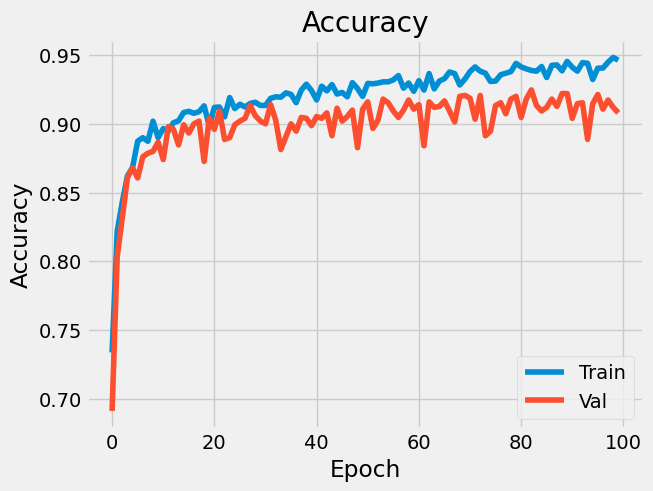

In [85]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
plt.show()

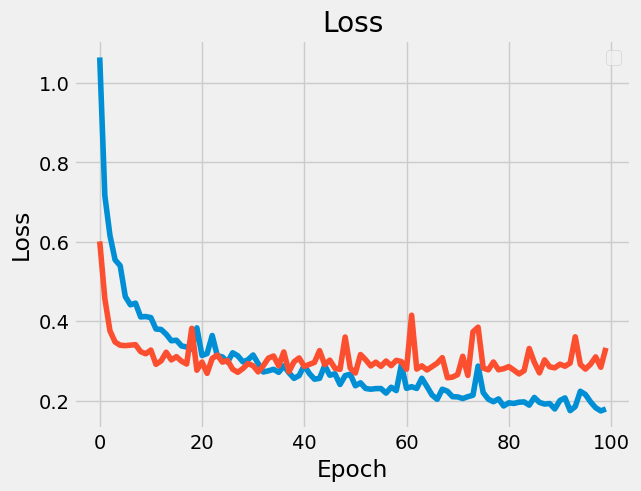

In [86]:
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [87]:
y_pred_ann = classification_report_on_train_and_val(model, X_train, y_train, X_val, y_val, X_test, True)

47/47 [==============================] - 0s 363us/step
Classification report on train dataset: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1848
           1       0.99      0.93      0.96       412
           2       0.77      0.88      0.82       452
           3       0.88      0.73      0.80       459
           4       0.99      0.96      0.97       277
           5       0.54      0.98      0.70        50

    accuracy                           0.94      3498
   macro avg       0.86      0.91      0.87      3498
weighted avg       0.95      0.94      0.94      3498

Classification report on validation dataset: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       793
           1       0.94      0.82      0.88       177
           2       0.74      0.81      0.77       194
           3       0.80      0.75      0.77       197
           4       0.88      0.89      0.88 